<a href="https://colab.research.google.com/github/capieroni/SCOPE/blob/OpenCV_train/SCOPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scientific Chart and Output Parsing Engine (SCOPE)

**The Scientific Chart and Output Parsing Engine** (SCOPE) Project is the
development and refinement of a system for recognizing and extracting charts and
graphs from scientific publications.

The overarching goal of this project is to build the foundation for a larger-scale program (REALM) that will be able to extract data from all figures within a scientific publication, with an emphasis on identifying “negative” or insignificant data.

Project objectives include accurately detecting and isolating charts and graphs, then converting these images into structured data for any future analysis. The project will also present accuracy metrics for each model iteration and refinement, emphasizing the specific improvements that I was able to achieve in performance optimization.

## Initial Setup

Mount Google Drive

In [1]:
#if not already mounted:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Grab pdfs from folder

In [2]:
import os

path = '/content/drive/MyDrive/SCOPE/scientific_pdfs'

#listing all PDF files
files = [f for f in os.listdir(path) if f.endswith('.pdf')]
print("PDF files:", files)

#if all works, the list should include all 13 files

PDF files: ['11386378.pdf', 'biochemj00515-0110.pdf', '19161491.pdf', '12381735.pdf', 'biochemj00498-0024.pdf', '20006622.pdf', '26525112.pdf', '20601430.pdf', '27965450.pdf', '31710151.pdf', 'nature11524.pdf', '12775706.pdf', '20595258.pdf']


Installing libraries

In [3]:
!pip install transformers #LayoutLMv2

!sudo apt install tesseract-ocr #pytesseract for OCR
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,955 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

## Step 2: Testing Program on one file

First, we'll start testing with one pdf that seems to have an easier layout to analyze:

20601430.pdf (A Glucose Transporter Can Mediate Ribose Uptake)

In [4]:
pdf_path = '/content/drive/MyDrive/SCOPE/scientific_pdfs/20601430.pdf'

### False Strategy (1): LayoutLMv2

In [ ]:
!pip install pdfplumber #parses pdf content

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 43.2 MB/s eta 0:00:00


Using pdfplumber to load the pages in iteration

In [ ]:
import pdfplumber

pdf = pdfplumber.open(path)
pages = [page for page in pdf.pages]

Then, we'll use LayoutLMv2 for layout extraction from the pages using a pre-trained model

First, I got an error saying I needed to import the detectron2 library:

In [ ]:
!pip install torch==1.12 torchvision torchaudio #PyTorch version compatible with detectron2

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.12/index.html #detectron2

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.12/index.html
ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2


In [ ]:
from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification
from PIL import Image

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutlmv2-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


ImportError: 
LayoutLMv2Model requires the detectron2 library but it was not found in your environment. Checkout the instructions on the
installation page: https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


After messing around for a little while, it turns out that LayoutLMv2 will not be able to be utilized as detectron2 is not compatible with the google colab environment. So instead, we will be turning to a different aproach

### False Strategy (2): YOLOv5

pdf2image for PDF page conversion and object detection using a lighter model, such as YOLOv5 or OpenCV-based detection, to locate charts in images.

Installing pdf2image for pdf page conversion and two different object detection models:

- PyTorch (for YOLOv5)
- OpenCV-based detection

In [5]:
!pip install pdf2image #handles pdf images

!pip install torch torchvision torchaudio #object detection model

!pip install opencv-python-headless #image processing

Then we'll install YOLOv5 from Github

The pro of this model is that it is a flexible, fast object detection model

In [6]:
!git clone https://github.com/ultralytics/yolov5  #clone the repository
%cd yolov5
!pip install -r requirements.txt  # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.66 MiB | 8.94 MiB/s, done.
Resolving deltas: 100% (11700/11700), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 15.6 MB/s eta 0:00:00


After running into an error we need to install Poppler to enable pdf2image to read and convert PDF files to images.

In [7]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (204 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123676 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


Specifying the pdf images folder:

In [8]:
output_folder = "/content/drive/MyDrive/REALM/20601430_outputs"

Now we'll use pdf2image to convert PDF pages into images and YOLOv5 to detect and extract charts from these images

In [9]:
import pdf2image

output_folder = "/content/drive/MyDrive/REALM/20601430_outputs"
os.makedirs(output_folder, exist_ok=True)

#convert pdf to image
images = pdf2image.convert_from_path(pdf_path, dpi=300)
for i, image in enumerate(images):
    image_path = f"{output_folder}/20601430_page_{i+1}.png"
    image.save(image_path, "PNG")

Now we'll run YOLOv5 for Object Detection

As a quick explaination, YOLOv5 will detect possible chart regions. It comes pre-trained but it may be need to be fine-tuned with some annotated samples of chart images

In [10]:
import torch #main library for PyTorch
from PIL import Image #python imaging library (to open, manipulate, and display images)
from pathlib import Path #just simplifies file management for me
import shutil #lets me copy the images over to my google drive folder

#loading the yolov5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-11-14 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 181MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


There are also other models we can try out if this accuracy is not that good.

In [11]:
#creating a folder to store images with chart/graph detections
output_detected_folder = "/content/drive/MyDrive/REALM/20601430_yolo_detections"
os.makedirs(output_detected_folder, exist_ok=True)

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


No charts detected in /content/drive/MyDrive/REALM/20601430_outputs/20601430_page_1.png, skipping.
No charts detected in /content/drive/MyDrive/REALM/20601430_outputs/20601430_page_2.png, skipping.


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


No charts detected in /content/drive/MyDrive/REALM/20601430_outputs/20601430_page_3.png, skipping.


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
WARNING ⚠️ NMS time limit 0.550s exceeded
Saved 1 image to runs/detect/exp


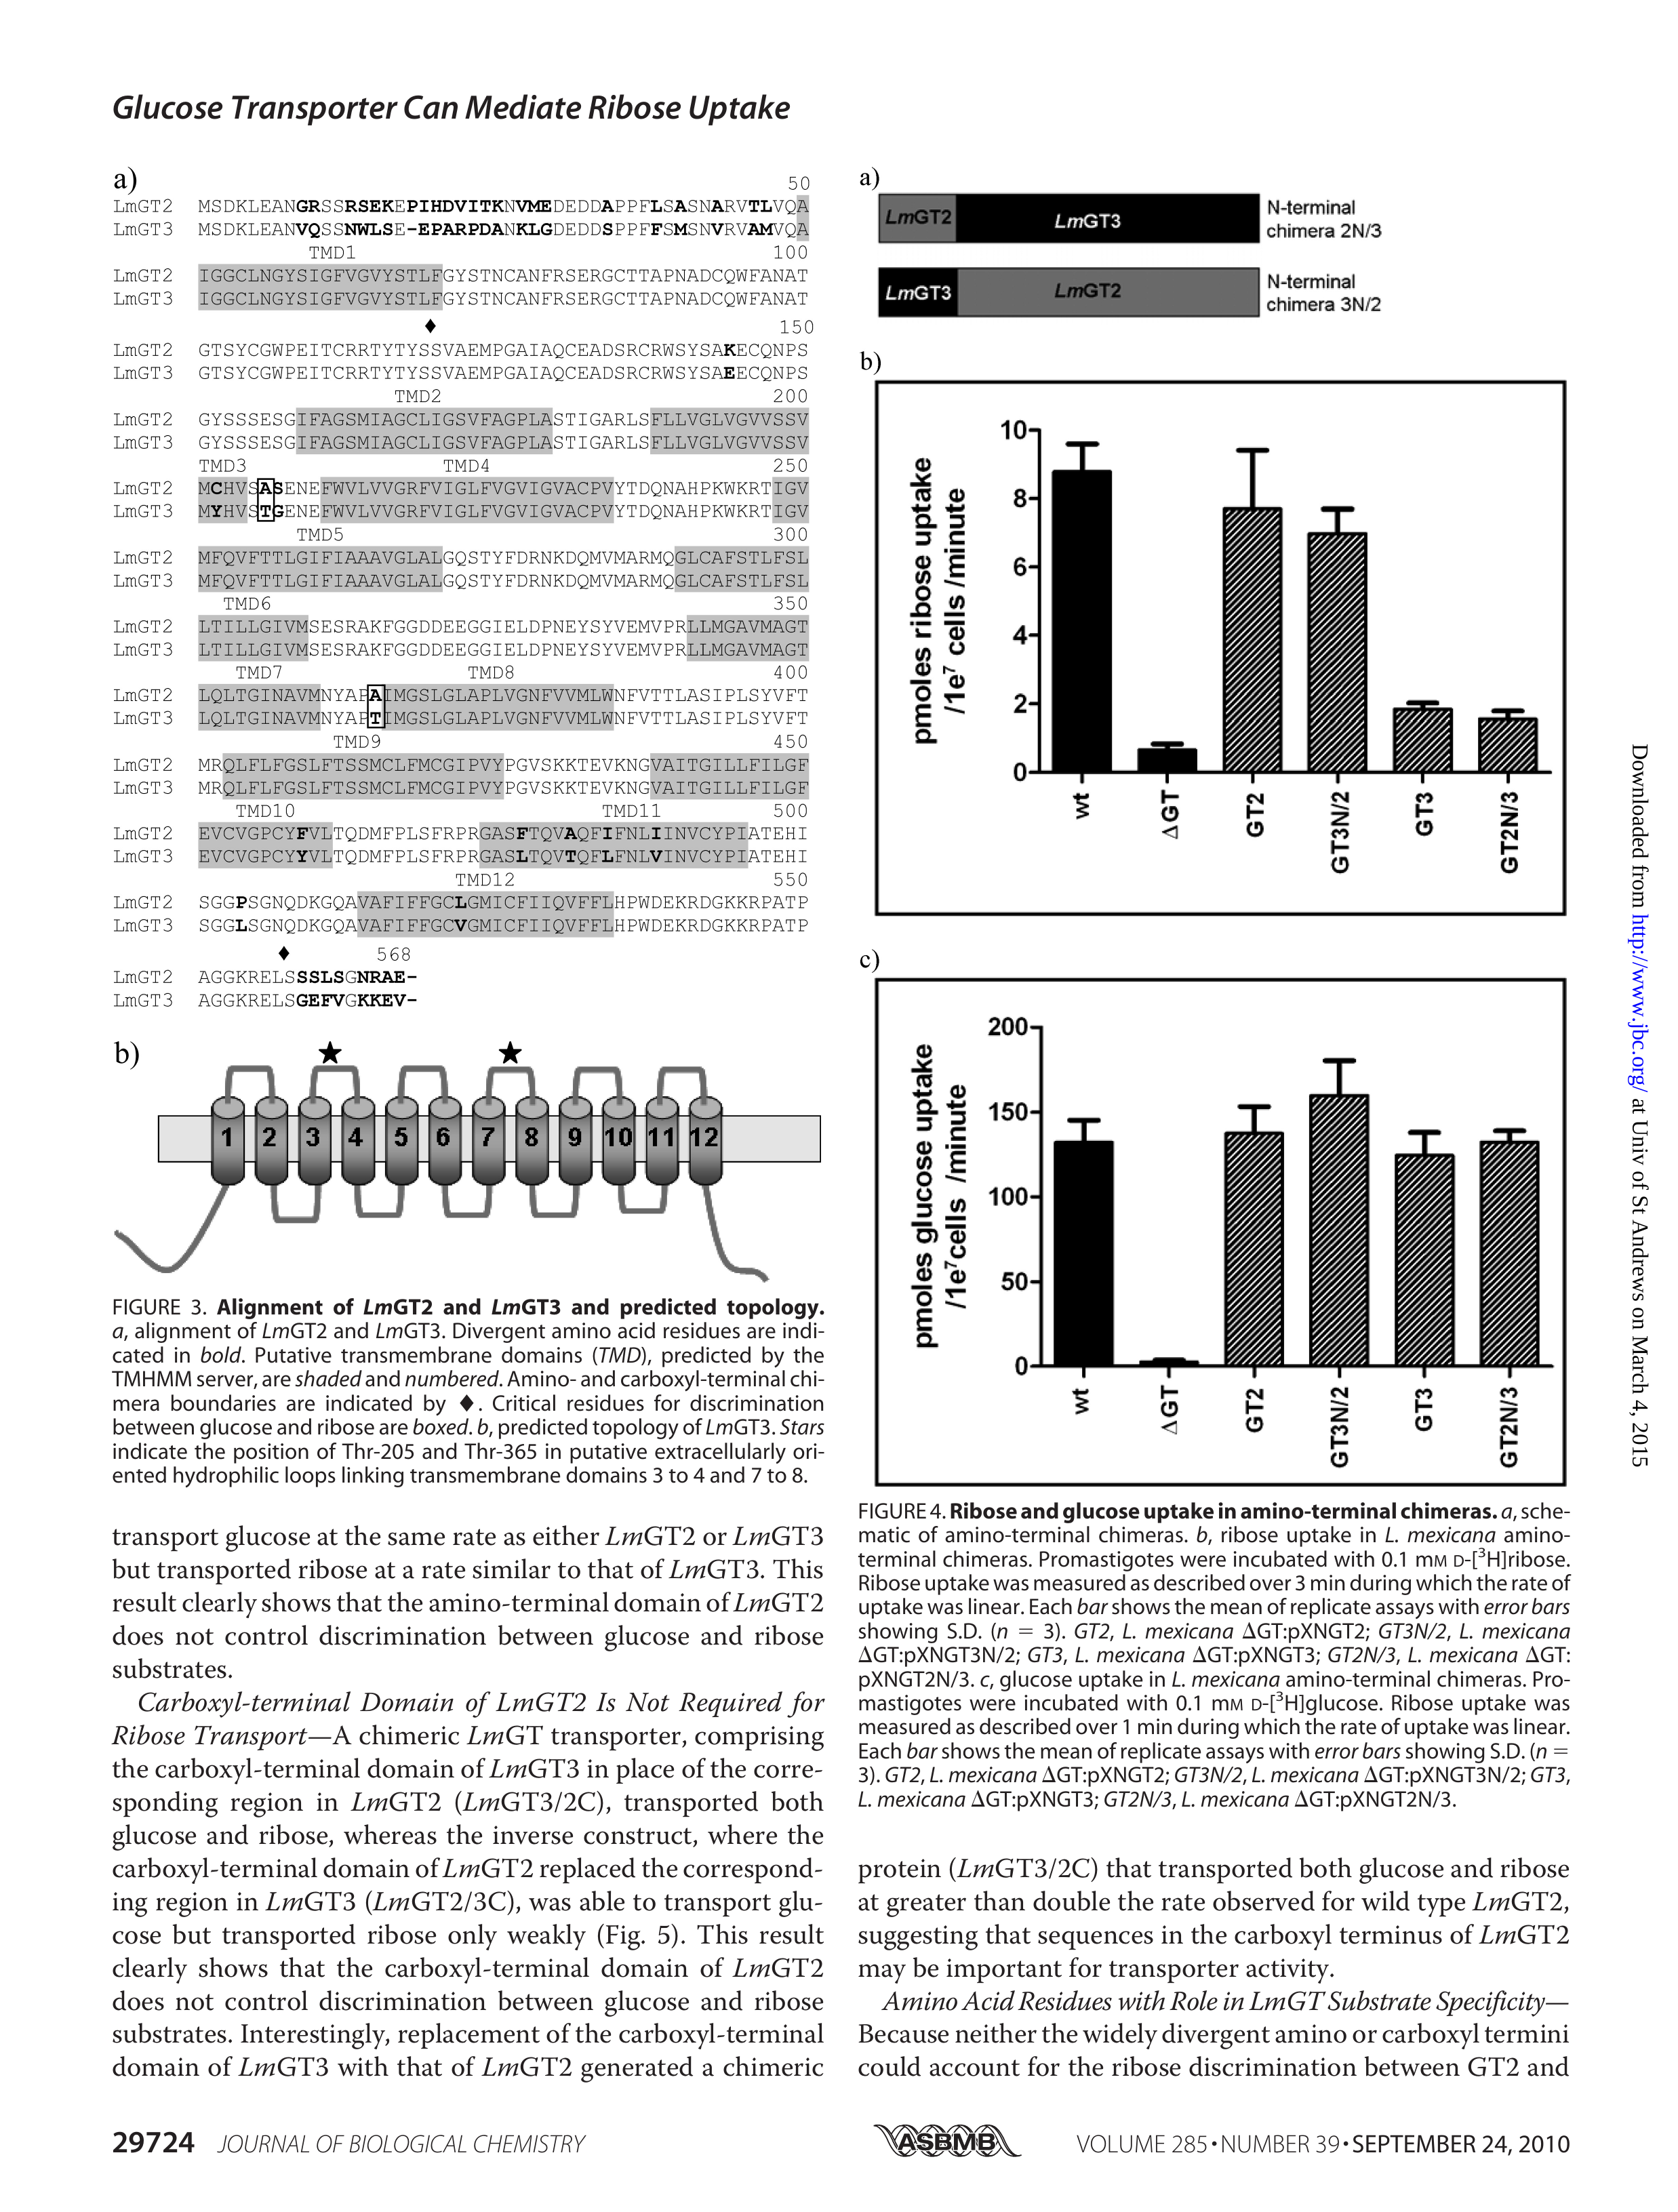

Saved detected image to /content/drive/MyDrive/REALM/20601430_yolo_detections/20601430_page_4.png


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


No charts detected in /content/drive/MyDrive/REALM/20601430_outputs/20601430_page_5.png, skipping.
No charts detected in /content/drive/MyDrive/REALM/20601430_outputs/20601430_page_6.png, skipping.
No charts detected in /content/drive/MyDrive/REALM/20601430_outputs/20601430_page_7.png, skipping.


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


No charts detected in /content/drive/MyDrive/REALM/20601430_outputs/20601430_page_8.png, skipping.
No charts detected in /content/drive/MyDrive/REALM/20601430_outputs/20601430_page_9.png, skipping.


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
Saved 1 image to runs/detect/exp2


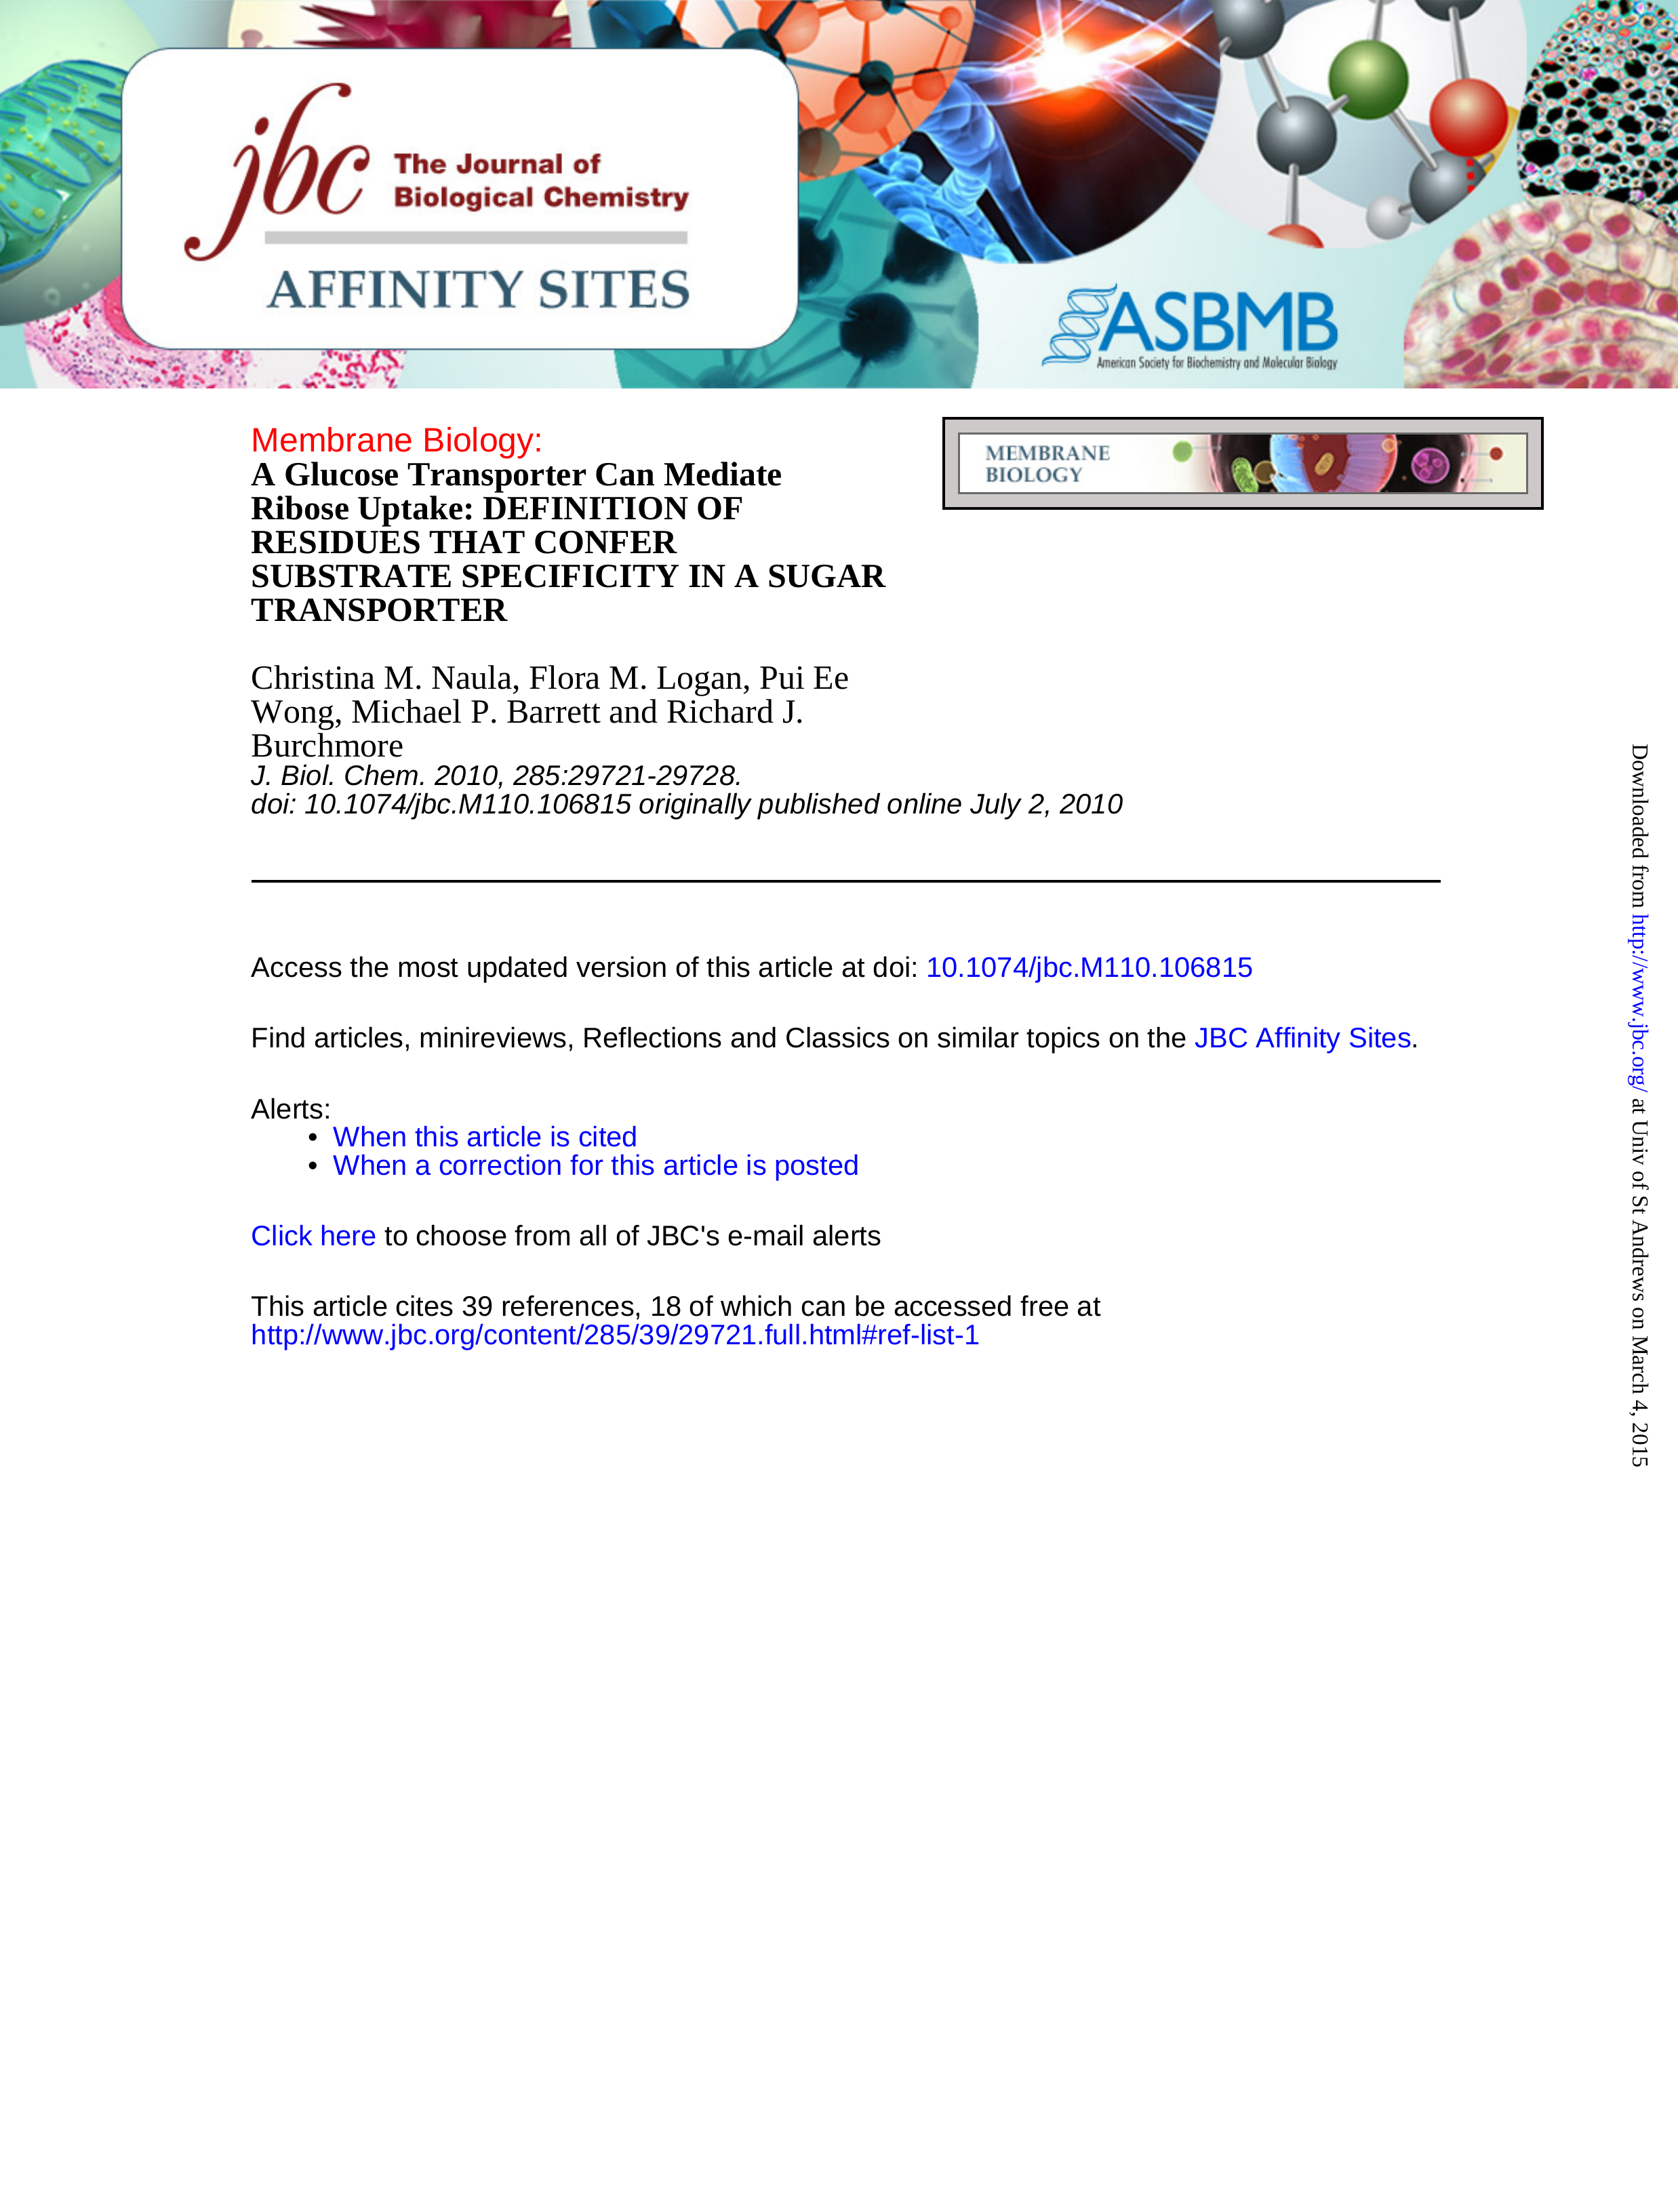

Saved detected image to /content/drive/MyDrive/REALM/20601430_yolo_detections/20601430_page_10.png


In [12]:
#running object detection on each page (looping)
for image_path in Path(output_folder).glob("*.png"):
    results = model(image_path)  #this runs the detection

    #check if there were any detections actually made
    if results.pred[0].shape[0] > 0:  #if num of shapes is more than 0 (aka shape detected)
        results.save()  #save the annotated image

        #display the image (just so we can see if its detection was accurate)
        display(Image.open(image_path))

        #copy images over to our folder in google drive
        detected_image_path = Path(output_detected_folder) / image_path.name
        shutil.copy(image_path, detected_image_path)
        print(f"Saved detected image to {detected_image_path}")
    else:
        print(f"No charts detected in {image_path}, skipping.")


Based on manually inspecting the images and whether they have figures or not- YOLOv5 only correctly detected on image with charts/graphs on it.

Page 3, Page 4 (detected), Page 5, and Page 6 should be the images with detected charts/graphs. It also incorrectly detected that Page 10 had a graph.

Thus, here is the breakdown:
True Positive: 1 (Page 4)
False Positive: 1 (Page 10)
False Negative: 3 (Page 3, 5, 6)
True Negative: 5 (Page 1, 2, 7, 8, 9)

Accuracy is defined as:

(TP + TN) / (TP + FP + FN + TN) =
(1 + 5) / (1 + 1 + 3 + 5) = 0.6 = 60%

Thus, our accuracy with this model is 60%.

So now we need to think about our future possibilities:
- Try another pre-trained model
- Fine-tune this model to be more accurate
- Train my own model

### Strategy 3: OpenCV

Let's try OpenCV

This code pulls the whole pages with bounding boxes over the graphs/charts

Imports needed

In [23]:
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import shutil

Making sure folders needed to store images are created and they exist

In [24]:
output_folder = "/content/drive/MyDrive/SCOPE/20601430_outputs"

detected_charts_folder = "/content/drive/MyDrive/SCOPE/20601430_opencv_detections"
cropped_charts_folder = "/content/drive/MyDrive/SCOPE/20601430_opencv_cropped"

In [27]:
for image_path in Path(output_folder).glob("*.png"):
    #read image in grayscale
    image = cv2.imread(str(image_path))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #adaptive thresholding (highlights chart areas)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    #canny edge detection
    edges = cv2.Canny(thresh, 100, 200)

    #find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #track if detections are made
    detections_made = False
    detected_region_counter = 0  #for cropped image naming

    #iteration through contours and filtering based on area and aspect ratio
    for contour in contours:
        min_area = 1000  #min area threshold for chart
        if cv2.contourArea(contour) > min_area:
            x, y, w, h = cv2.boundingRect(contour)

            #filter based on aspect ratio (if needed)
            aspect_ratio = w / float(h)
            if 0.5 < aspect_ratio < 2.0:  #adjust aspect ratio range
                #mark if there was a detection
                detections_made = True

                #drawing bounding box on image
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                #crop detected chart
                cropped_region = image[y:y+h, x:x+w]
                cropped_image_path = Path(cropped_charts_folder) / f"{image_path.stem}_chart_{detected_region_counter}.png"
                cv2.imwrite(str(cropped_image_path), cropped_region)
                detected_region_counter += 1

    #save and display (only there was a detection)
    if detections_made:
        #save annotated image to folder
        annotated_image_path = Path(detected_charts_folder) / f"annotated_{image_path.name}"
        cv2.imwrite(str(annotated_image_path), image)

        #display annotated image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  #converting to RGB for matplotlib display
        plt.title(f"Detected charts in {image_path.name}")
        plt.axis("off")
        plt.show()
    else:
        print(f"No charts detected in {image_path.name}, skipping.")


No charts detected in 20601430_page_2.png, skipping.
No charts detected in 20601430_page_3.png, skipping.
No charts detected in 20601430_page_8.png, skipping.
No charts detected in 20601430_page_7.png, skipping.


I ran this code 3 times and it was consistent all 3 times

From this initial run of OpenCV we can see that it detects 35 charts/graphs from this scientific publication.

To calculate this accuracy we will use a similar method than before, except manually count the number of charts that actually exist

*   Page 3 has 3 graphs
*   Page 4 has 2 (readable) charts
*   Page 5 has 4 (readable) charts
*   Page 6 has 2 charts

Thus a total of 11 charts and graphs in this particular pdf (20601430.pdf)

Our model detected 35 of these charts, but let's calculate a very simple accuracy of these detections:

8 (true detections) / 11 (total) = 72.7% accuracy

This is definitely an accuracy we can work with, the issue is to fine tune the model to

a. recognize graphs as well and

b. stop detecting letters as figures


Also, here a function to clear my folder for each run:

In [18]:
def clear_folder(folder_path):
    shutil.rmtree(folder_path, ignore_errors=True)
    os.makedirs(folder_path, exist_ok=True)

In [26]:
clear_folder(detected_charts_folder)
clear_folder(cropped_charts_folder)

In [20]:
for img_path in Path(output_folder).glob("*.png"):
    # Read the image and convert to grayscale
    img = cv2.imread(str(img_path))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to highlight potential chart areas
    thresh_img = cv2.adaptiveThreshold(
        gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Perform Canny edge detection
    edge_img = cv2.Canny(thresh_img, 100, 200)

    # Find contours in the edge-detected image
    cnts, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Track detections and initialize counter for cropped images
    found_chart = False
    chart_count = 0

    # Iterate through each contour and apply refined filters
    for c in cnts:
        min_area = 3000  # Increased area threshold to filter out small shapes
        if cv2.contourArea(c) > min_area:
            x, y, w, h = cv2.boundingRect(c)

            # Filter based on aspect ratio
            ratio = w / float(h)
            if 0.5 < ratio < 2.5:

                # Circularity check to ignore circular shapes (likely small letters)
                perimeter = cv2.arcLength(c, True)
                area = cv2.contourArea(c)
                circularity = 4 * 3.14159 * (area / (perimeter * perimeter)) if perimeter != 0 else 0
                if circularity > 0.6:  # Circular shapes have a higher circularity
                    continue  # Skip this contour if it is likely circular

                found_chart = True  # Mark that a detection has been made

                # Draw a bounding box on the detected chart area
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # Crop the detected region and save it
                cropped_img = img[y:y+h, x:x+w]
                crop_path = Path(cropped_charts_folder) / f"{img_path.stem}_chart_{chart_count}.png"
                cv2.imwrite(str(crop_path), cropped_img)
                chart_count += 1

    # Save and display the image with annotations if detections were made
    if found_chart:
        anno_path = Path(detected_charts_folder) / f"annotated_{img_path.name}"
        cv2.imwrite(str(anno_path), img)

        # Display the annotated image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected charts in {img_path.name}")
        plt.axis("off")
        plt.show()
    else:
        print(f"No charts detected in {img_path.name}, skipping.")


No charts detected in 20601430_page_9.png, skipping.
No charts detected in 20601430_page_2.png, skipping.
No charts detected in 20601430_page_3.png, skipping.
No charts detected in 20601430_page_1.png, skipping.
No charts detected in 20601430_page_6.png, skipping.
No charts detected in 20601430_page_4.png, skipping.
No charts detected in 20601430_page_5.png, skipping.
No charts detected in 20601430_page_8.png, skipping.
No charts detected in 20601430_page_7.png, skipping.


Now the model is not able to recognize ANY charts/graphs. FAIL

In [28]:
clear_folder(detected_charts_folder)
clear_folder(cropped_charts_folder)

In [29]:
for img_path in Path(output_folder).glob("*.png"):
    # Read the image and convert to grayscale
    img = cv2.imread(str(img_path))
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to highlight potential chart areas
    thresh_img = cv2.adaptiveThreshold(
        gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Perform Canny edge detection
    edge_img = cv2.Canny(thresh_img, 100, 200)

    # Find contours in the edge-detected image
    cnts, _ = cv2.findContours(edge_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to track area statistics and regions
    detected_areas = []
    found_chart = False
    chart_count = 0

    # First pass: Collect contour areas and bounding boxes
    for c in cnts:
        area = cv2.contourArea(c)
        min_area = 1000  # Minimum area threshold for chart detection

        if area > min_area:
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = w / float(h)

            # Basic check on aspect ratio to capture potential chart areas
            if 0.5 < aspect_ratio < 2.0:
                # Save bounding box and area for post-processing
                detected_areas.append((area, x, y, w, h))

    # Calculate an average area to filter out smaller shapes
    if detected_areas:
        avg_area = sum([a[0] for a in detected_areas]) / len(detected_areas)
        refined_min_area = avg_area * 0.3  # Allow flexibility, setting minimum area to 30% of average

        # Second pass: Filter contours by refined area and draw bounding boxes
        for area, x, y, w, h in detected_areas:
            if area >= refined_min_area:
                found_chart = True  # Confirm detection of charts

                # Draw bounding box on the detected chart area
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # Crop the detected region and save it
                cropped_img = img[y:y+h, x:x+w]
                crop_path = Path(cropped_charts_folder) / f"{img_path.stem}_chart_{chart_count}.png"
                cv2.imwrite(str(crop_path), cropped_img)
                chart_count += 1

    # Save and display the image with annotations if detections were made
    if found_chart:
        anno_path = Path(detected_charts_folder) / f"annotated_{img_path.name}"
        cv2.imwrite(str(anno_path), img)

        # Display the annotated image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected charts in {img_path.name}")
        plt.axis("off")
        plt.show()
    else:
        print(f"No charts detected in {img_path.name}, skipping.")


No charts detected in 20601430_page_2.png, skipping.
No charts detected in 20601430_page_3.png, skipping.


<ipython-input-29-8b742004b3e5>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 8))


No charts detected in 20601430_page_8.png, skipping.
No charts detected in 20601430_page_7.png, skipping.


Accuracy goes up when we refine it this way. It is NOT filtering out noise though still. I'm thinking about using image size or file size as a method to filter out noise as it is practically impossible for a figure to be that small.

## Step 3 : Generalizing to any pdf entered